# using samplers with the `gcepy` likelihood

3 Oct 2023

Samuel D. McDermott

## imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

first, I load the package that contains the definition of the log likelihood (you need to make sure that you have installed with `python setup.py install` first) with `import gcepy as gp`. Then I'll load some samplers, which operate in similar but meaningfully different ways (both of which I'll use in this notebook). Finally, I'll load the just-in-time compilation feature of jax, which is very useful, and `jax.numpy` and `numpy` in case I need them

In [2]:
import gcepy as gp

import dynesty as dn
import numpyro as nr

from jax import jit
from jax import numpy as jnp
import numpy as np

In [3]:
hm_lowpriors, hm_highpriors = gp._hm.pmin, gp._hm.pmax

lm_lowpriors, lm_highpriors = gp._lm.pmin, gp._lm.pmax

be aware that `jax` has strong feelings about randomness -- for more of an explanation, see https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers

In [4]:
import jax.random as jr
rng_key = jr.PRNGKey(0)

here is an example of how to use random number generation in practice

In [5]:
gp.lnlike('low', jr.uniform(rng_key,(5,))*(lm_highpriors[:5] - lm_lowpriors[:5]) + lm_lowpriors[:5],
          bin_no=5, ex_num=1)

Array(-2.2230745e+10, dtype=float32)

you ought to run `jax.random.split` every time you want a new random number from the same distribution: note that the first two are identical, because we reused the key

In [6]:
rng_key, rng_key_ = jr.split(rng_key)

gp.lnlike('low', jr.uniform(rng_key,(5,))*(lm_highpriors[:5] - lm_lowpriors[:5]) + lm_lowpriors[:5], bin_no=5, ex_num=1),\
gp.lnlike('low', jr.uniform(rng_key,(5,))*(lm_highpriors[:5] - lm_lowpriors[:5]) + lm_lowpriors[:5], bin_no=5, ex_num=1),\
gp.lnlike('low', jr.uniform(rng_key_,(5,))*(lm_highpriors[:5] - lm_lowpriors[:5]) + lm_lowpriors[:5], bin_no=5, ex_num=1)

(Array(-1.447981e+12, dtype=float32),
 Array(-1.447981e+12, dtype=float32),
 Array(-636932.1, dtype=float32))

In [7]:
rng_key = jr.PRNGKey(0) #"resetting" this for later

# low-dimensional model

## nested sampling with `dynesty`

First, I'll demonstrate the usage of `dynesty` in this context

It's natural to run `dynesty` first, since `dynesty` doesn't need initial values (this is because a nested sampler's goal is to explore the entire posterior space, including regions that may seem to have low likelihoods but which contain a large volume)

first of all, we have to define a "prior transform." This function is necessary because dynesty always samples from the unit cube, and it needs a way to transform these samples to the parameters of interest

In [8]:
def ptform(x, dim):
    return x*(lm_highpriors[:dim] - lm_lowpriors[:dim]) + lm_lowpriors[:dim]
jptform = jit(ptform, static_argnums=(1,))

specifying some model hyperparameters: in this notebook, we'll find the posteriors for energy bin Python-indexed-5, regarding model excess 1 (DM), which has 5 parameters

In [9]:
EBIN, EXNUM, PDIM = 5, 1, 5

first we create the sampler; this requires two callables and a declaration of the parameter space dimension. The two callables are the likelihood and the transform from the unit cube

then we run the sampler. The most meaningful hyperparameter is `dlogz`, which is a stopping criterion and roughly sets an error bar on the precision of the evidence and on the likelihood. I'm doing `dlogz=10` here, but we used `dlogz=1` for our paper

In [10]:
sampler_dn = dn.NestedSampler(lambda x: gp.lnlike('low', x, EBIN, ex_num=EXNUM),
                              lambda x: jptform(x, PDIM), PDIM)

sampler_dn.run_nested(dlogz=10)

/Users/sammcd/micromamba/envs/v3/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
5003it [00:18, 201.86it/s, bound: 56 | nc: 13 | ncall: 59340 | eff(%):  8.431 | loglstar:   -inf < -195035.359 <    inf | logz: -195051.161 +/-  0.175 | dlogz: 861.279 > 10.000]   /Users/sammcd/micromamba/envs/v3/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Users/sammcd/micromamba/envs/v3/lib/python3.12/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determi

the posterior is described in `{sampler name}.results`

`{sampler name}.results.summary()` gives the hyperparameters from the run

In [11]:
sampler_dn.results.summary()
sampler_dn.results.logz[-1], sampler_dn.results.logl[-1]

Summary
nlive: 500
niter: 9571
ncall: 133360
eff(%):  7.552
logz: -194175.457 +/-  1.948


(-194175.4572576606, -194152.4375)

## NUTS implementation of HMC in `numpyro`: low-dimensional model

Now I'll run the No-U-Turn Sampler version of Hamiltonian Monte Carlo using `numpyro`.

This example does not harness the full, abstract strength of numpyro as a general probabilistic programming language. Instead, I'm just using the NUTS HMC by telling the sampler that the potential energy is equal to the negative log probability.

again, first we create the sampler; this requires one callable and a specification of some hyperparameters. I'm choosing a small number of warmup steps because I believe our initial point will be a good point. (If you simply wanted to skip running `dynesty`, you could instead specify more warmup steps.)

then we run the sampler. I'm initializing this run from the final state of the `dynesty` run, but you could start from anywhere you like.

Note that `numpyro` explicitly requires the random key (mentioned above)

In [12]:
sampler_nr = nr.infer.MCMC(nr.infer.NUTS(potential_fn = lambda t: -gp.lnlike('low', t, bin_no=EBIN, ex_num=EXNUM)),
                           num_samples=10000, num_warmup=100, jit_model_args=True, chain_method='vectorized')

sampler_nr.run(rng_key, init_params = jnp.zeros(PDIM))

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10100/10100 [01:19<00:00, 127.00it/s, 23 steps of size 4.35e-02. acc. prob=0.91]


the timing is similar for this model, but the cool thing about HMC/NUTS is that it does a very good job even in very high dimensions

`numpyro` does not default to keeping all samples.
Instead, only the final point is kept readily accessible, which is fine because HMC is reversible.
So we must call `{sampler name}.get_samples()` first before we can assess the properties of the posterior.
This is relevant because NUTS is not monotonically decreasing in potential energy.
So it's possible (even likely) that the final state will not be the maximum likelihood point.

In [13]:
samples_nr = sampler_nr.get_samples()

Then we have to evaluate the likelihood at every sample

In [14]:
lls_nr = jnp.array([gp.lnlike('low', x, bin_no=EBIN, ex_num=EXNUM) for x in samples_nr])

Now let's compare

In [15]:
sampler_dn.results.logl[-1], float(lls_nr.max()), float(-sampler_nr.last_state.potential_energy), int(lls_nr.argmax())

(-194152.4375, -194151.84375, -194152.6875, 1299)

the HMC sampler found a point that was better than its final point by a small Delta log likelihood of about 1 (and better than the nested sampler by a similar amount)

## corner plots: low-dimensional models

Because we don't want to do all 14 energy bins for all 6 models of interest in this notebook, we won't make spectrum plots here (though the examples shown here are perfectly parallelizable, so any multi-core cluster you have access to will do a good job with these code snippets with minimal changes).

Instead, I'll make the corner plots.

In [16]:
import pygtc

In [17]:
names=['pi+brem', 'ICS', 'bub', 'iso', 'DM']

the `numpyro` results automatically drop the "warmup" steps, but the `dynesty` results have some "burn-in" phase that we don't want to plot -- you can set this however you like. I'm (semi-arbitrarily) dropping the first third of the samples.

Note that the nested samples are not directly proportional to the posterior (HMC does not require weights because its samples *do* have this feature), but `dynesty` will calculate us the correctly weighted (or resampled) samples using `{results}.samples_equal()`

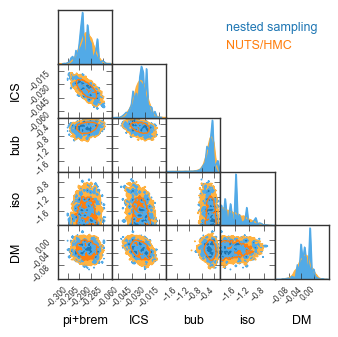

In [18]:
pygtc.plotGTC(chains = [sampler_dn.results.samples_equal(), samples_nr],
              smoothingKernel = 0.1,
#               paramRanges = [(-.35,-.25), (-.15,.05), (-1.2, .4), (-2, 0), (-.2,.2)],
              chainLabels = ['nested sampling', 'NUTS/HMC'],
              paramNames = names, #paramRanges = [list(x) for x in bounds[:-1]],
             )
plt.show()

the nested sampler results are a bit broader and less smooth, but generally these agree well

# high-dimensional model: `dynesty` vs `numpyro/NUTS`

now that you've seen how to run everything in the context of the low-dimensional, astrophysically motivated, model, I'll show how to run the high-dimensional model as well. Note that **this will not work unless you've gotten the correct template files**, which are *not* included in the github repository by default. You must email a request for these models because neither I nor my coauthors made the original models (though we do have reprojected, rebinned versions available). However, once you do (and once you edit the `setup.py` file in the appropriate way in the `package_data` line), it all runs exactly the same, as I demonstrate here

again, I'm defining a prior transform, now for different (and more numerous) priors

In [28]:
hm_highpriors.at[8:10].set([6,4])

Array([10., 10., 10., 10., 10., 10., 10., 10.,  6.,  4., 10., 10., 10.,
       10., 10., 10.,  1.,  1.,  1.,  1.], dtype=float32)

In [29]:
def ptform_h(x, dim):
    return x*(hm_highpriors[:dim] - hm_lowpriors[:dim]) + hm_lowpriors[:dim]
jptform_h = jit(ptform_h, static_argnums=(1,))

using the same energy bin but changing the example (now both the DM and the "boxy bulge plus" are independently free), such that the parameter dimension increases from 5 to 20

In [30]:
EBIN, EXNUM, PDIM = 5, 6, 20

and then I run the dynamic nested sampler in the exact same way -- the only difference from the user's perspective is `gp.lnlike('low'...)` becomes `gp.lnlike('high'...)`

In [31]:
h_sampler_dn = dn.NestedSampler(lambda x: gp.lnlike('high', x, EBIN, ex_num=EXNUM),
                                lambda x: jptform_h(x, PDIM), PDIM)
h_sampler_dn.run_nested(dlogz=10)

ValueError: The log-likelihood of live point is invalid.

In [ ]:
h_sampler_dn.results.summary()

this took quite a bit longer (though still not so bad!) -- yet the evidence is much lower

In [23]:
h_sampler_dn.results.logz[-1] - sampler_dn.results.logz[-1]

-540.083386035607

just to prove the goodness of the scaling in parameter dimension for HMC/NUTS, I'll run `numpyro` again as well

In [24]:
h_sampler_nr = nr.infer.MCMC(nr.infer.NUTS(potential_fn = lambda t: -gp.lnlike('high', t, bin_no=EBIN, ex_num=EXNUM),
                            max_tree_depth=(10,6)),
                           num_samples=10000, num_warmup=100, jit_model_args=True, chain_method='vectorized')

h_sampler_nr.run(rng_key, init_params = h_sampler_dn.results.samples[-1])

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10100/10100 [01:50<00:00, 91.56it/s, 6 steps of size 8.60e-02. acc. prob=0.82]


the time scaling from the low-dimensional model to the high-dimensional model is a bit better for HMC/NUTS

no reason not to show the corner plots:

In [25]:
h_samples_nr = h_sampler_nr.get_samples()
h_lls_nr = jnp.array([gp.lnlike('high', x, bin_no=EBIN, ex_num=EXNUM) for x in h_samples_nr])

In [26]:
h_names=['HI$_{1}$', 'HI$_{2}$', 'HI$_{3}$', 'HI$_{4}$', 'H2$_{1}$', 'H2$_{2}$',
        'H2$_{3}$', 'H2$_{4}$', 'pres', 'nres', 'ICS$_{1a}$', 'ICS$_{1b}$',
       'ICS$_{1c}$', 'ICS$_{2}$', 'ICS$_{3}$', 'ICS$_{4}$', 'bub', 'iso', 'BB+', 'DM']

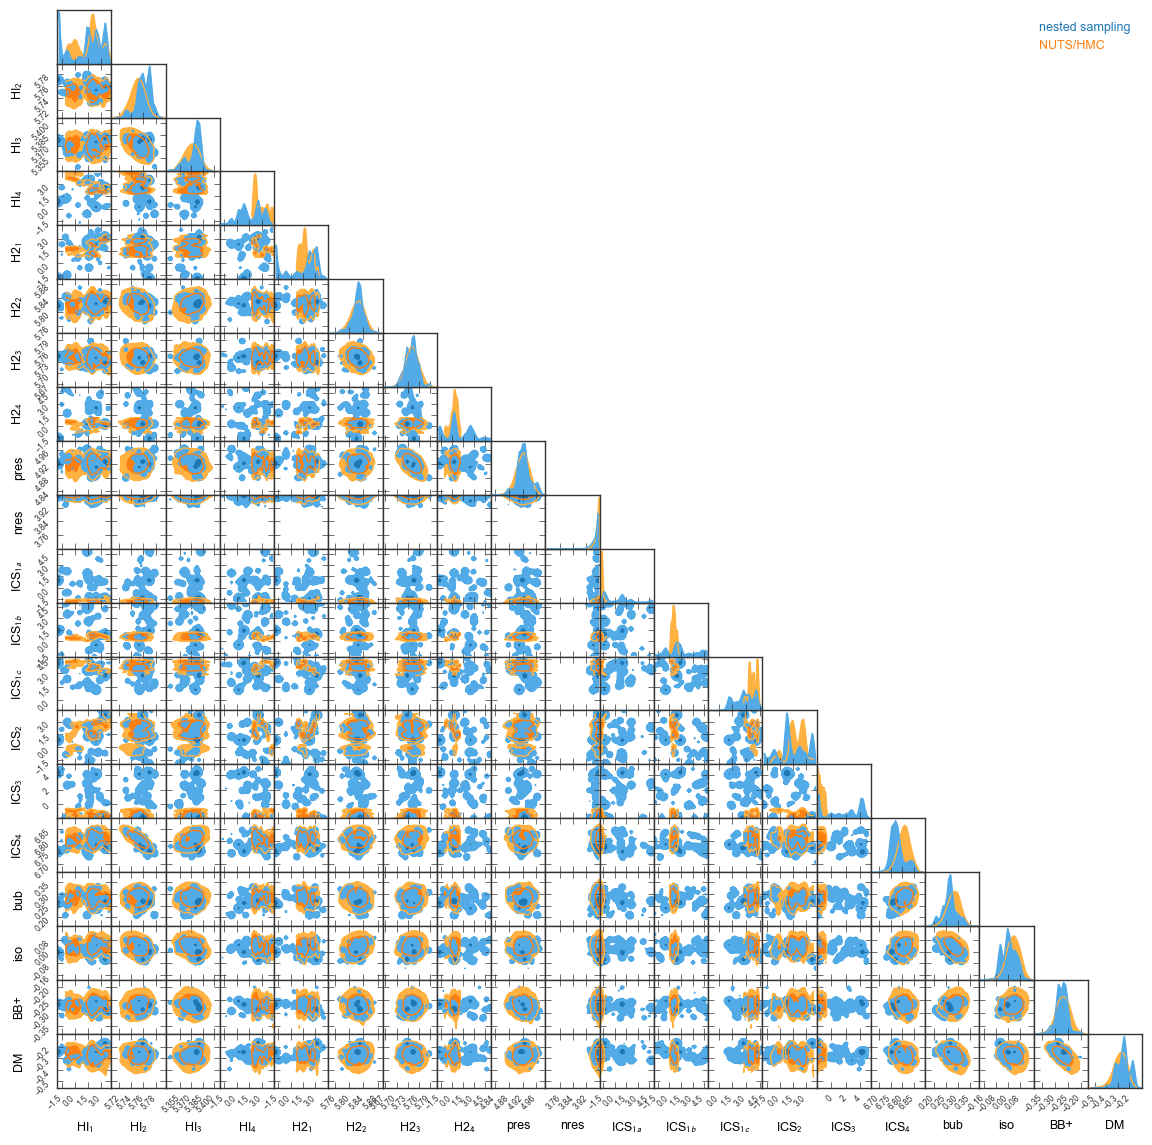

In [27]:
pygtc.plotGTC(chains = [h_sampler_dn.results.samples_equal(), h_samples_nr],
              chainLabels = ['nested sampling', 'NUTS/HMC'],
              paramNames = h_names, #paramRanges = [list(x) for x in bounds[:-1]],
             )
plt.show()

seemingly the only parameter that is prior dominated is `nres`, but we don't want this to be very large, so this is a touchy issue to solve

In [28]:
h_sampler_dn.results.logl[-1], \
float(h_lls_nr.max()), float(-h_sampler_nr.last_state.potential_energy), int(h_lls_nr.argmax())

(-194647.640625, -194643.34375, -194648.140625, 4401)

the difference between the `numpyro` and `dynesty` posteriors is more pronounced here -- the HMC results lead to tighter constraints, and the log likelihood is substantially higher. Clearly, HMC provides increasing advantages in higher dimensions (though having a good model makes much more of a difference)

# microcanonical HMC

This part of the notebook will demonstrate how to use the new [microcanonical Hamiltonian Monte Carlo developed by Robnik and Seljak](https://github.com/JakobRobnik/MicroCanonicalHMC/). This requires us to use smoothed-out priors*, so the likelihood is a little different than in the preceding cases. So I don't think we can exactly compare the `logz` values any more, but it's still instructive to compare the corner plots.

Step one, import the `mchmc` code and the `jax.value_and_grad` function

(*when I tried sampling the same likelihood as with NUTS, I found `nan`s everywhere, so it seems `mchmc` _really_ dislikes hard/uniform/boxy priors for reasons I don't exactly understand)

In [29]:
import sampling.sampler as mchmc # `sampling` is the current, dangerous, namespace for the package
from jax import value_and_grad as jvg

The API for this is a little different than above, but not terribly so. You create a class that must have an attribute `d` representing the dimension and a method `grad_nlogp` that returns the value and gradient of the function at a given point. Optionally you can specify `transform` if you have a lot of nuisance parameters that you know you want to project out (but I don't, so it just returns `x`) and `prior_draw` if you don't want to specify initial conditions (but I do, for clarity, so this is irrelevant).

In [30]:
mc_potential_fn = lambda t: -gp.lnlike('high_smooth', t, bin_no=EBIN, ex_num=EXNUM)
vg = jvg(mc_potential_fn)

class C_hm:
    def __init__(self, d=20):
        self.d = d
    def grad_nlogp(self, x):
        return vg(x)
    def transform(self, x):
        return x
    def prior_draw(self, key):
        scale = (hm_highpriors[:self.d] - hm_lowpriors[:self.d])
        shift = hm_lowpriors[:self.d]
        return jr.uniform(key, shape = (self.d, )) * scale + shift

I'll sample this with three different initial conditions: first using the final point from the `dynesty` results, then with the final point from the `numpyro` results, and finally with all parameter values at 0 (this is not expected to be a good point, but it is within the priors). I'll include timing information manually to demonstrate the speed (this doesn't seem to have `tqdm` ...yet)

In [31]:
from datetime import datetime as dt

In [32]:
ta = dt.now()
mchmcd_target = C_hm(PDIM)
mchmcd_sampler = mchmc.Sampler(mchmcd_target)
mchmcd_samples = mchmcd_sampler.sample(10000, x_initial=h_sampler_dn.results.samples[-1])
tb = dt.now()
delt = tb-ta
print(delt)

0:00:23.279286


In [33]:
ta = dt.now()
mchmcn_target = C_hm(PDIM)
mchmcn_sampler = mchmc.Sampler(mchmcn_target)
mchmcn_samples = mchmcn_sampler.sample(10000, x_initial=h_samples_nr[int(h_lls_nr.argmax())])
tb = dt.now()
delt = tb-ta
print(delt)

0:00:21.489310


In [34]:
ta = dt.now()
mchmc0_target = C_hm(PDIM)
mchmc0_sampler = mchmc.Sampler(mchmc0_target)
mchmc0_samples = mchmc0_sampler.sample(10000, x_initial=jnp.zeros(PDIM))
tb = dt.now()
delt = tb-ta
print(delt)

0:00:21.604221


they all take a similar amount of time, and they're all very fast! Let's plot them all, alongside the previous results. (I'll also throw out half of the poorly initialized `mchmc` results since they're even more spread out otherwise.)

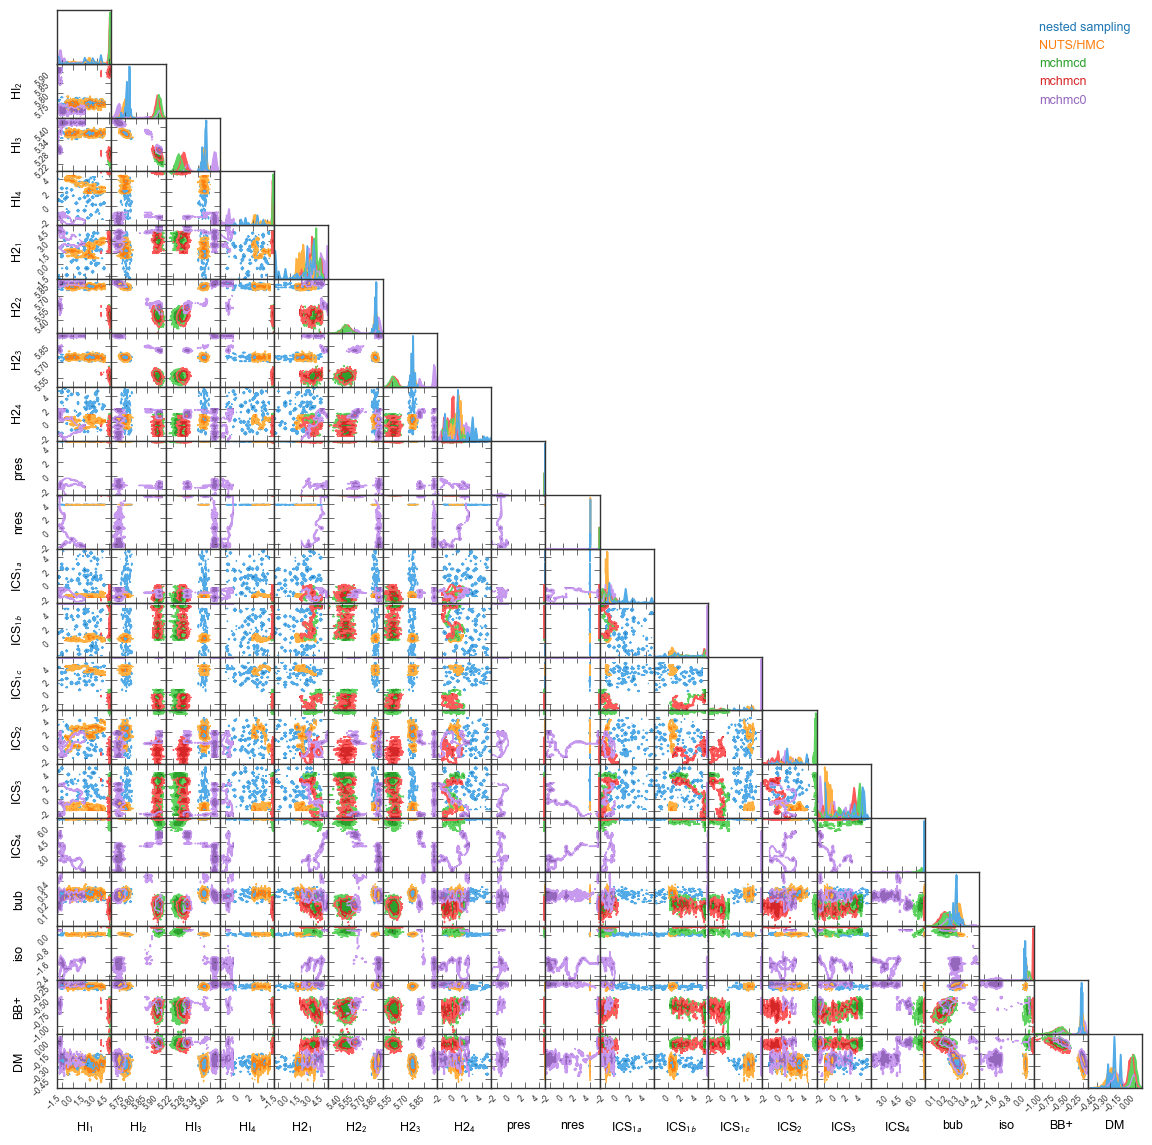

In [35]:
pygtc.plotGTC(chains = [h_sampler_dn.results.samples_equal(), h_samples_nr,
                        mchmcd_samples, mchmcn_samples, mchmc0_samples[5000:]],
              smoothingKernel = 0.1,
              chainLabels = ['nested sampling', 'NUTS/HMC',
                             'mchmcd', 'mchmcn', 'mchmc0'],
              paramNames = h_names, #paramRanges = [list(x) for x in bounds[:-1]],
             )
plt.show()

The posteriors are pretty all over the place for the poorly initialized `mchmc` samples, in pretty good agreement for the well-initialized `mchmc` samples (with a little burn-in for the results starting from the `dynesty` point), and generally (but by not always) these results overlap with the results from the `numpyro` run. Because I needed to smooth out the priors for `mchmc`, the results for those extend beyond the samples of the other methods and it seems to find more prior-dominated parameters (`HI2`, `pres`, `nres`, `ICS1a`, `ICS4`). This suggests that we didn't quite capture the maximum likelihood point in our prior range. So, _in principle_ we should rerun everything with those parameter ranges extended, but this is difficult without leading to `nres` values of O(30%) of the total.

To conclude this comparison, let's see how the log-likelihoods compare at the final points (this time using the `high_smooth` model to put everything on somewhat more equal footing):

In [36]:
np.max([gp.lnlike('high_smooth', s, bin_no=EBIN, ex_num=EXNUM) for s in mchmcd_samples]), \
np.max([gp.lnlike('high_smooth', s, bin_no=EBIN, ex_num=EXNUM) for s in mchmcn_samples]), \
np.max([gp.lnlike('high_smooth', s, bin_no=EBIN, ex_num=EXNUM) for s in mchmc0_samples]), \
np.max([gp.lnlike('high_smooth', s, bin_no=EBIN, ex_num=EXNUM) for s in h_samples_nr]), \
np.max([gp.lnlike('high_smooth', s, EBIN, EXNUM) for s in h_sampler_dn.results.samples])

(-194280.86, -194295.03, -194534.36, -194643.47, -194647.75)

much better results from `mchmc`! Though, again, this had "smooth" priors so it certainly explored some parameter space that the other models didn't have access to